# Learning Track Origin

Question: If we add an auxiliary loss so that the network learns the origin of the tracks that it just saw, could this help the classification?


<img src="../figures/PU_studies/roc_noGarbage.pdf" width="400">


**Motivation:**

We see that a lot can be gained by teaching the network to ignore PU + GEANT tracks.

- We'll need some hyperparameter tuning to balance out the track classification w/ the ultimate probability, but this should be an easy (+ fun) study to do!

- Since I'm already using the keras functional api, now just use a multi-output model. 

In [1]:
import numpy as np
import h5py
import sys
import os
import pandas as pd
import xarray as xr

# Visulalizations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Functions from other modules that I've written
sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Design choice: Should I predict 5 or 4 classes?
- Start w/ 5 since this requires less code, and JF uses the information about the decay topology.

I need the sequences output for the auxiliary loss, but I need the final hidden state for the regular net.

In [2]:
# Get the truth values for the other loss function
dataFile = '../data/mc16d'
dataTag = '3m_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataFile,dataTag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataFile,dataTag))

To train on the gpu, which doesn't have Py tables, I need to save the track origin truth labels. 

So I'm going to go ahead and do that *here* in this notebook, and then load them in from hdf5 files on the gpu.

*However, since this step is a bit time consuming, I'm only going to create this new file if my first one isn't here.*

In [3]:
vStr = "sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f2_name = "{}/data_{}_5trkClasses.hdf5".format(dataFile,dataTag)

if not os.path.exists(f2_name):

    f1 = h5py.File("{}/data_{}.hdf5".format(dataFile,dataTag),"r")
    f2 = h5py.File(f2_name,"w")

    for key in f1.keys():
        print(key)
        f2.create_dataset(key, data=f1[key][:])

    # Then add on the trk origin truth labels
    for mode in ['train', 'test']:
        key = 'y_trk_'+mode
        val = trk_xr.loc[f1['ix_'+mode][:], :, 'orig'].values
        f2.create_dataset(key, data=val)

    print("\nf2 keys:\n")
    for key in f2.keys():
        print(key)

    f1.close()
    f2.close()
    
else:
    print(f2_name + " already exists")

../data/mc16d/data_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev_5trkClasses.hdf5 already exists


In [4]:
nFeatures=13
timeSteps=15
modelDir='../models/mc16d/'
modelName = "LSTM_trkClass_50units_10dense_3m_15trks_{}_sd0_rev_alpha0.5".format(vStr)

In [5]:
# Ok, let's load in the model + the weights in separately
m = LSTM_trkClass(modelDir=modelDir, timeSteps=timeSteps, modelName=modelName,
                  nFeatures=nFeatures, loadModel=True, doEmbedding=False)

Initialize method from myModel()
alpha= 0.5
Loading weights for previously trained model


Jet_class_acc
Jet_class_loss
Trk_class_acc
Trk_class_loss
loss
val_Jet_class_acc
val_Jet_class_loss
val_Trk_class_acc
val_Trk_class_loss
val_loss


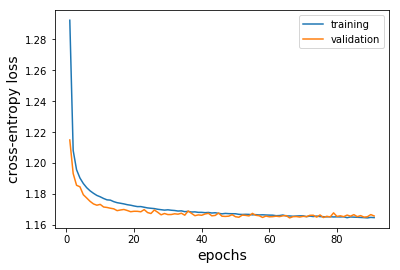

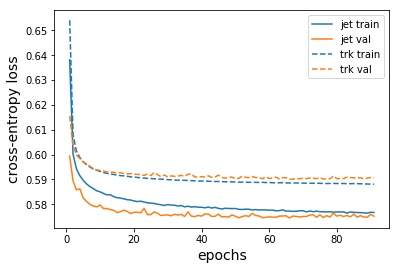

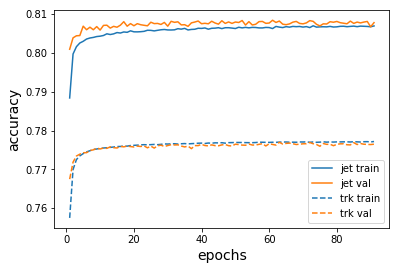

In [6]:
trainingMetrics(m.modelName)

Next, load in the roc curves!

In [7]:
f2 = h5py.File(f2_name,"r")
    
X_tr = f2['X_train'][:]
    
X_te = f2['X_test'][:]
y_te = f2['y_test'][:]
y_trk_te = f2['y_trk_test'][:].astype(int)
ix_te = f2['ix_test'][:]

f2.close()

In [8]:
X_tr.shape

(1500000, 15, 13)

Ok, just have to be a bit careful with these multi-output models.

In [9]:
out = m.eval(X_te)

In [10]:
out.shape

(1500000, 4)

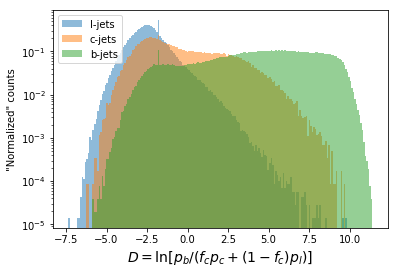

In [11]:
leffs, ceffs, beffs = [], [], []

leff, ceff, beff = sigBkgEff(m,X_te,y_te,ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)


../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


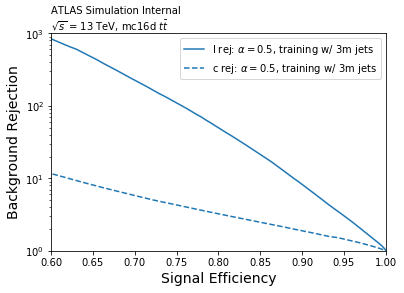

In [12]:
labels = [r'$\alpha = 0.5$, training w/ 3m jets']

btagROC(beffs, leffs, ceffs, labels) 

Wow, I think this looks super cool! I should really overlay the roc curves though before I try to claim that this is better though.

In [13]:
modelName = "LSTM_50units_10dense_3m_15trks_{}_sd0_rev".format(vStr)

m_old = myLSTM(modelDir=modelDir, timeSteps=timeSteps, modelName=modelName,
               nFeatures=nFeatures, loadModel=True, doEmbedding=False)

Initialize method from myModel()
Loading previously trained LSTM


acc
loss
val_acc
val_loss


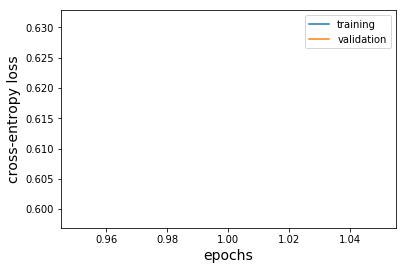

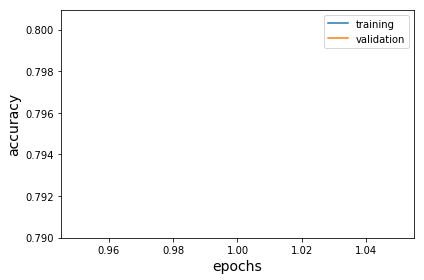

In [14]:
trainingMetrics(m_old.modelName)

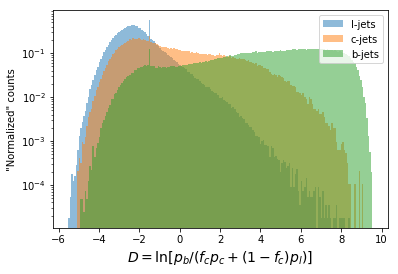

In [15]:
leff, ceff, beff = sigBkgEff(m_old,X_te,y_te,ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


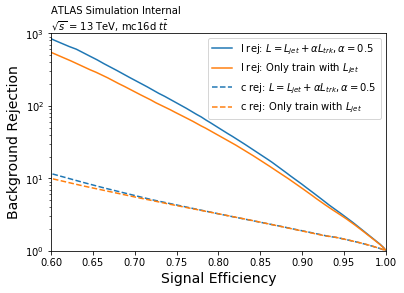

In [16]:
labels = [r'$L = L_{jet} + \alpha L_{trk}, \alpha = 0.5$', r'Only train with $L_{jet}$']

btagROC(beffs, leffs, ceffs, labels, tag='trkOrig_13hitVars',subDir='mc16d')

Ok, so at the moment we're training models with 5 classes, but it might be useful to combine the b and c categories into a single category to represent the HF tracks.

**Perhaps it would be useful to use TSNE as a useful metric for whether it would be useful to *combine* the tracks from the HF decay into a single class, or whether I should combine PU + GEANT into a single `garbage` category, similar to the TCT???**


But before just running ahead with this, I think I'm going to look at what kind of information is encoded in the hidden state by projecting in 2d with
1. PCA
2. tSNE

**Need to be able to access the rnn hidden states!**

- Initial simple question: how many tracks are we talking about in the test set?

In [17]:
X_te.shape

(1500000, 15, 13)

In [18]:
trk_mask = getTrkMask(X_te) #(np.sum(X_te, axis=-1) != 0)
nTrks_te = (trk_mask).sum(axis=-1)

In [19]:
nTrks_te[:5]

array([ 6, 10,  1,  3,  5])

In [20]:
jet_df.loc[ix_te,'ip3d_ntrk'][:5]

1300538     6.0
2555241    10.0
1574134     1.0
1766750     3.0
390538      5.0
Name: ip3d_ntrk, dtype: float64

So there are multiple ways to access this variable!

**Q:** How many tracks are in the test set?

In [21]:
print('trks in test set: {}'.format(nTrks_te.sum()))

trks in test set: 7447241


Ok, so I'm running PCA to reduce a 50d vector to 2d, and this will result in a scatter plot with ~ 7.5m tracks (although perhaps it will be more visually appealing to only plot a subset of the tracks.)

Plan for accessing the hidden state:
- Define a new model with the (50d) LSTM as the output classification
- Then I can load in the weights (by name) from the model trained with the aux loss function :)

In [22]:
nHidden=50

trk_inputs = Input(shape=(timeSteps,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=True, name="LSTM")(masked_input)

seq_model = Model(inputs=trk_inputs, outputs=lstm)

seq_model.set_weights(m.model.get_weights())

In [23]:
# I might not have to load in these weights individually after the layers for
# the two models have the same names!
# seq_model.get_layer('Trk_inputs').set_weights(m.model.get_layer('Trk_inputs').get_weights())
# seq_model.get_layer('LSTM').set_weights(m.model.get_layer('LSTM').get_weights())

In [24]:
#seq_model.get_weights()

**Efficiency tables**

Ok, so we see above that there is a *marginal* improvement gain for these models that have been trained with the track origin.

Below, it seems like a big part of this improvement *might* be because of an improved fragmentation vs. weak track separation and not because of the garbage tracks.

To verify this hypothesis, I'm going to take a look at the track classifier portion of my network, and see what types of tracks it's succeeding and failing at!

- Use the multi-index tables, because by automating the creation of these pretty tables, it minimizes the places that human error can enter!

**Track classification**

- Ok, so I've been using $\alpha = 0.5$, so the track classifier is (obviously) not as important as the jet classifer.
- However, it's useful to tell the story (and understand for myself) exactly *where* these performance gains are coming from!


In [25]:
trk_out = m.eval(X_te,trk_out=True)
trk_out.shape

(1500000, 15, 5)

Ok, now need to convert these probabilities into the truth labels, but not to worry, I can do this!

In [26]:
trk_max_prob = np.argmax(trk_out,axis=-1)
trk_max_prob

array([[1, 1, 4, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [27]:
#trk_pred = np.where(trk_max_prob==4, -1, trk_max_prob)

In [28]:
trk_pred

NameError: name 'trk_pred' is not defined

In [ ]:
trk_true_class = np.where(y_trk_te==-1,4,y_trk_te)

In [ ]:
trk_classes = ["HF: b", "HF: c", "Frag","GEANT","PU"]
nTrkClasses = len(trk_classes)

In [ ]:
trkEff_df = pd.DataFrame(np.zeros((nTrkClasses,nTrkClasses)),
                       index=trk_classes,columns=trk_classes)

trkEff_df.index.name = "target class"
trkEff_df.columns.name = "predicted class"

trkEff_df.head()

Ok, so to implement this study, I really need to access all of my track variables, and predicted track classes, so I'll need to define a new model `trk_out` similar to how I truncated my model to explore the track class before (or at least, I think this is something along the lines of what I need to do.)

Note: below shows a super easy way to access the flatten the track variables using the track mask!

In [ ]:
trk_mask.shape

In [ ]:
y_trk_te[trk_mask].shape

In [ ]:
np.min(y_trk_te[trk_mask]), np.max(y_trk_te[trk_mask])

Ok, I need to figure out how this `to_categorical` function works!

In [ ]:
# Quick test to make sure that I understand what these things mean!
from keras.utils.np_utils import to_categorical
y_trk_ex = [-1, 0, 1, 2, 3]

to_cat_ex = to_categorical(y_trk_ex, num_classes=nTrkClasses) 

In [ ]:
to_cat_ex

Ok, so 0-3 represent the same things as before, -1 just got mapped to 4!

In [ ]:
nTestTrks = np.sum(trk_mask)
print(nTestTrks)

for ti in range(nTrkClasses):
    nTrkCat = np.sum(to_cat_out[:,:,ti][trk_mask])
    print("ti = {}, {}".format(ti, nTrkCat / nTestTrks))

In [ ]:
trk_classes

In [ ]:
# Flatten out the trackless variables
t_true = trk_true_class[trk_mask]
t_pred = trk_max_prob[trk_mask]

print(np.min(t_true),np.max(t_true))
print(np.min(t_pred),np.max(t_pred))

for i_true, tag_true in enumerate(trk_classes):
    
    den_mask = (t_true == i_true)
    
    for i_pred, tag_pred in enumerate(trk_classes):

        num_mask = den_mask & (t_pred == i_pred)
        
        eff = np.sum(num_mask) / np.sum(den_mask)
        
        print("{} trk classified as {}: {}".format(tag_true, tag_pred,eff))
        
        trkEff_df.loc[tag_true,tag_pred] = eff
        

In [ ]:
trkEff_df.round(decimals=2)

In [ ]:
# Sanity check: Do the rows sum to1?
np.sum(trkEff_df.values, axis=-1)

**Conclusions:**
- HF b-tracks are *most* likely to be classified as cs. The network is essentially *learning to play it safe* for these tracks, which probably makes sense because HF tracks from the c in the tertiary decay will have *larger* IPs.
- For c-tracks, it's actually *more likely* to misclassify them as fragmentation.
- It's learned *very well* how to classify fragmentation tracks
- It is *not* very good at classifying GEANT or PU tracks, this might be a motivation for *not* combining them into a single garbage class, something that I also noticed when looking at the variable distributions, which are acutally quite different.


**New number 1 goal: Look at a training where the HF tracks are combined into a single category!**

Need to create a dataset with a redefinition of the truth labels for the tracks.
- 0: HF
- 1: Frag
- 2: GEANT
- 3: PU

Also (for testing purposes), make a dataset that only has 1k train + test entries.

In [ ]:
vStr = "sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)
miniDataTag = '1k' + dataTag[2:]

f3_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)
f4_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,miniDataTag)
miniJets = 1000

if not os.path.exists(f3_name):

    f1 = h5py.File("{}/data_{}.hdf5".format(dataFile,dataTag),"r")
    f3 = h5py.File(f3_name,"w")
    f4 = h5py.File(f4_name,"w")

    for key in f1.keys():
        f3.create_dataset(key, data=f1[key][:])
        f4.create_dataset(key, data=f1[key][:miniJets])

    # Then add on the trk origin truth labels
    for mode in ['train', 'test']:
        key = 'y_trk_'+mode
        val = trk_xr.loc[f1['ix_'+mode][:], :, 'orig'].values
        
        # Re-doing the truth labeling
        for ti_new, ti_old,  in enumerate([1,2,3,-1]):
            val = np.where(val==ti_old, ti_new, val)

        f3.create_dataset(key, data=val)
        f4.create_dataset(key, data=val[:miniJets])
        
    print("\nf3 keys:\n")
    for key in f3.keys():
        print(key)

    f1.close()
    f3.close()
    f4.close()
    
else:
    print(f3_name + " already exists")

Ok, 

In [ ]:
m.modelName

**PCA**

Recall: We want the input to PCA to be an array with
`nTestTrks x 50`

In [ ]:
# Get the activations, I'm going to run PCA on a subset of the events in the test set...
# because it takes awhile!
nJets = 50000
out_te = seq_model.predict(X_te[:nJets])

In [ ]:
out_te.shape

In [ ]:
out_list = [out_te[i,:ni,:] for i,ni in enumerate(nTrks_te[:nJets])]

In [ ]:
out_list[0].shape

In [ ]:
PCA_input = np.concatenate(out_list,axis=0)

In [ ]:
PCA_input.shape

In [ ]:
pca = PCA(n_components=2)
X_xform = pca.fit_transform(PCA_input)

In [ ]:
y_te.shape

In [ ]:
y_trk_te[trk_mask].shape

Oh, I want to know what my plot says, i.e, need some colors!!

In [ ]:
nExs = 10000

s = X_xform[:nExs,0]
t = X_xform[:nExs,1]

y_trk_masked = y_trk_te[trk_mask]

for oi, c, l,a in zip([-1,0,1,2,3],['C0','C2','C1','C4','C3'],
                    trk_classes,[1,.7,.5,.3,.3]):
    
    mask = (y_trk_masked[:nExs] == oi)
    
    plt.scatter(s[mask],t[mask],s=10,alpha=a,label=l,color=c)
    
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()


plt.savefig('../figures/mc16d/PCA_5trkClass.png')
plt.show()
    

Ok, so it seems to have learned some reprementation of the tracks, the HF tracks are more clustered to one side, but it's a bit hard to tell...

**Ideas:**
1. I could remake this plot for the model trained without the auxiliary loss to see whether this is helping at all
2. I can put a dense layer between the LSTM and classification, and maybe this dense layer will help with the classification, or be more intuitive for this plot?
3. Right now I'm asking the LSTM layer to learn two things, perhaps it would be useful to look if these blobs are actually color coding the track category?


**tSNE**

In [ ]:
PCA_input.shape

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(PCA_input[:10000])

In [ ]:
nExs = 10000

s = X_embedded[:nExs,0]
t = X_embedded[:nExs,1]

y_trk_masked = y_trk_te[trk_mask]

for oi, c, l in zip([-1,0,1,2,3],['C0','C2','C1','C4','C3'],
                    ["PU","HF: b", "HF: c", "Frag","GEANT"]):
    
    mask = (y_trk_masked[:nExs] == oi)
    
    plt.scatter(s[mask],t[mask],s=10,alpha=0.5,label=l,color=c)
    
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend()

plt.savefig('../figures/mc16d/TSNE_5trkClass.png')
plt.show()
    

Ok... so it looks like there are two different heavy flavor classes, possibly for the jets originating from the b or c.

- A way I could test this would be to 

## Training on four track classes

Let's see if we can get better performance by restricting the track categories to 4 (combining HF tracks) or 3 (combining garbage tracks).

Since the most egregious mistake was that it was confused about the nature of the HF tracks, I'm going to compare with the training with the four tracks, and hopefully it looks ok!!

In [ ]:
?LSTM_trkClass

In [ ]:
modelName = "LSTM_4_trkClass_50units_10dense_15trkDense_3m_15trks_{}_sd0_rev_alpha0.5".format(vStr)

In [ ]:
m_4trkClass = LSTM_trkClass(modelDir=modelDir, timeSteps=timeSteps, modelName=modelName,
                            nFeatures=nFeatures, loadModel=True, doEmbedding=False,
                            nTrkClasses=4, nDenseTrk=15)

In [ ]:
%%bash
../models/mc16d/LSTM_4_trkClass_50units_10dense_15trkDense_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev_alpha0.5_weights.h5

In [ ]:
m_4trkClass.modelName

In [ ]:
m_4trkClass.model.get_weights()

### Open the test set for getting the discriminant

In [ ]:
f3 = h5py.File(f3_name,"r")
    
X_tr = f3['X_train'][:]
    
X_te = f3['X_test'][:]
y_te = f3['y_test'][:]
y_trk_te = f3['y_trk_test'][:].astype(int)
ix_te = f3['ix_test'][:]

f3.close()

### Training metrics

In [ ]:
trainingMetrics(m_4trkClass.modelName)

In [ ]:
%%bash
ls ../models/mc16d/LSTM_4_trkClass_50units_10dense_15trkDense_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev_alpha0.5_history.hdf5

### roc curves + comparison

In [ ]:
leff, ceff, beff = sigBkgEff(m_4trkClass,X_te,y_te,ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
labels = [r'$L = L_{jet} + \alpha L_{trk}, \alpha = 0.5$, 5 track classes', 
          'Only train with $L_{jet}$', 
          r'$L = L_{jet} + \alpha L_{trk}, \alpha = 0.5$, 4 track classes']

btagROC(beffs, leffs, ceffs, labels, tag='cf_4Classes',subDir='mc16d')

In [ ]:
m.modelName

Ok, so it really doesn't look like it helps...

### Ideas of stuff to try next
- So in looking at the training metrics, when I simplified the problem for the track classifier, the track accuracy is doing a lot better, even though this *isn't* the goal of this problem. So maybe I should try repeating the trainings for some *smaller* $\alpha$
    - $\alpha = 0.1, 0.2, 0.3, 0.4$
- In the previous model, I was looking at not having the dense layer before classification. Maybe putting this in is hurting us, because the hidden state of the LSTM isn't needing to do as much work to make a decision? 
    - I could try training one of the (smaller) $\alpha$s without this dense layer (like for $\alpha = 0.2$)
- Maybe I have the wrong early stopping criterion?
    - This model is trained stopping on val_loss, but probably the Jet_class_loss or Jet_class_acc would be a preferable model to stop on?
    - I'm having a technical issue EarlyStopping on something else, so maybe I'll continue to work on this later?
- I think it's still useful to make the efficiency tables and visualizations with this current $\alpha$ just to understand where the performance gains are coming from!


### efficiency tables

**Goal:** 
I want to see what's the biggest mistake for the network right now!

In [ ]:
trk_out = m_4trkClass.eval(X_te,trk_out=True)

In [ ]:
trk_max_prob = np.argmax(trk_out,axis=-1)

In [ ]:
trk_classes = ["HF","Frag","GEANT","PU"]
nTrkClasses = len(trk_classes)

trkEff_df = pd.DataFrame(np.zeros((nTrkClasses,nTrkClasses)),
                       index=trk_classes,columns=trk_classes)

trkEff_df.index.name = "target class"
trkEff_df.columns.name = "predicted class"

trkEff_df.head()

In [ ]:
# Flatten out the trackless variables
t_true = trk_true_class[trk_mask]
t_pred = trk_max_prob[trk_mask]

print(np.min(t_true),np.max(t_true))
print(np.min(t_pred),np.max(t_pred))

for i_true, tag_true in enumerate(trk_classes):
    
    den_mask = (t_true == i_true)
    
    for i_pred, tag_pred in enumerate(trk_classes):

        num_mask = den_mask & (t_pred == i_pred)
        
        eff = np.sum(num_mask) / np.sum(den_mask)
        
        print("{} trk classified as {}: {}".format(tag_true, tag_pred,eff))
        
        trkEff_df.loc[tag_true,tag_pred] = eff

In [ ]:
trkEff_df.round(decimals=2)

### visualizations